In [1]:
# Necessary imports
import os
import pathlib
os.environ['USE_PYGEOS'] = '0'
import gc
import numpy as np
from itertools import product
from datetime import datetime
from zoneinfo import ZoneInfo
from dotenv import load_dotenv
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors
import ee
from georeader.readers import ee_query
import folium
import geemap.foliumap as geemap
import shapely
from shapely.geometry import box, Point, MultiPoint
from shapely.ops import nearest_points


from ml4floods.data.worldfloods import dataset
from ml4floods.data import utils
from ml4floods.visualization import plot_utils

from db_utils import DB

# Uncomment this to suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# Set bucket will not be requester pays
utils.REQUESTER_PAYS_DEFAULT = False

In [2]:
import rasterio
from rasterio.io import MemoryFile
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling


## Load environment and project details

As with the other notebooks, we load credentials and project details from a hidden ```.env``` file.

In [3]:
# Load environment variables (including path to credentials) from '.env' file
env_file_path = "../.env"

# Uncomment for alternative version for Windows (r"" indicates raw string)
#env_file_path = r"C:/Users/User/floodmapper/.env"

assert load_dotenv(dotenv_path=env_file_path) == True, "[ERR] failed to load environment!"
assert "GOOGLE_APPLICATION_CREDENTIALS" in os.environ, "[ERR] missing $GOOGLE_APPLICATION_CREDENTIAL!"
assert "GS_USER_PROJECT" in os.environ, "[ERR] missing $GS_USER_PROJECT!"
key_file_path = os.environ["GOOGLE_APPLICATION_CREDENTIALS"]
assert os.path.exists(key_file_path), f"[ERR] Google credential key file does not exist: \n{key_file_path} "
assert "ML4FLOODS_BASE_DIR" in os.environ, "[ERR] missing $ML4FLOODS_BASE_DIR!"
base_path = os.environ["ML4FLOODS_BASE_DIR"]
assert os.path.exists(base_path), f"[ERR] base path does not exist: \n{base_path} "
bucket_name = os.environ["BUCKET_URI"]
assert bucket_name is not None and bucket_name != "", f"Bucket name not defined {bucket_name}"

print("[INFO] Successfully loaded FloodMapper environment.")

[INFO] Successfully loaded FloodMapper environment.


In [4]:
# Connect to the database (point to the .env file for credentials)
db_conn = DB(env_file_path)

[INFO] Connecting to DB 'floodmapper-db'.
[INFO] Connection successfully established.


In [5]:
# Initialise the Google Earth Engine connection.
# Follow instructions on login prompt, if required.
ee.Initialize()

In [6]:
# EDIT THIS CELL: All work is conducted under a unique session name
session_name = "boulia_test"

## Retrieve the session parameters from the database

Edit the following cell to set the session name and retrieve the flood map parameters, including mapping grid and affected LGAs.

In [7]:
tz = ZoneInfo("UTC")
midnight = datetime.min.time()

# Query the floodmapping parameters from the DB
query = (f"SELECT flood_date_start, flood_date_end, "
         f"ref_date_start, ref_date_end, bucket_uri "
         f"FROM session_info "
         f"WHERE session = %s;")
data = (session_name,)
session_df = db_conn.run_query(query, data, fetch=True)
flood_start_date = session_df.iloc[0]["flood_date_start"]
flood_start_date = datetime.combine(flood_start_date, midnight).replace(tzinfo=tz)
flood_end_date = session_df.iloc[0]["flood_date_end"]
flood_end_date = datetime.combine(flood_end_date, midnight).replace(tzinfo=tz)
ref_start_date = session_df.iloc[0]["ref_date_start"]
ref_start_date = datetime.combine(ref_start_date, midnight).replace(tzinfo=tz)
ref_end_date = session_df.iloc[0]["ref_date_end"]
ref_end_date = datetime.combine(ref_end_date, midnight).replace(tzinfo=tz)
bucket_uri = session_df.iloc[0]["bucket_uri"]

# Query the selected grid positions and LGAs
query = (f"SELECT sp.patch_name, ST_AsText(gr.geometry), gr.lga_name22 "
         f"FROM session_patches sp "
         f"INNER JOIN grid_loc gr "
         f"ON sp.patch_name = gr.patch_name "
         f"WHERE sp.session = %s ;")
data = (session_name,)
grid_sel_df = db_conn.run_query(query, data, fetch=True)

# Format the results into a correct GeoDataFrame
grid_sel_df['geometry'] = gpd.GeoSeries.from_wkt(grid_sel_df['st_astext'])
grid_sel_df.drop(['st_astext'], axis=1, inplace = True)
grid_sel_gdf = gpd.GeoDataFrame(grid_sel_df, geometry='geometry', crs="EPSG:4326")
grid_sel_gdf.drop_duplicates(subset=["patch_name"], inplace=True)
print(f"[INFO] {len(grid_sel_gdf)} grid patches selected.")

# Query the affected LGA shapes
lgas_sel_lst = grid_sel_df.lga_name22.unique().tolist()
query = (f"SELECT DISTINCT lga_name22, ST_AsText(geometry_col) "
         f"FROM lgas_info "
         f"WHERE lga_name22 IN %s ;")
data = (tuple(lgas_sel_lst),)
lgas_sel_df = db_conn.run_query(query, data, fetch=True)

# Format the results into a correct GeoDataFrame
lgas_sel_df['geometry'] = gpd.GeoSeries.from_wkt(lgas_sel_df['st_astext'])
lgas_sel_df.drop(['st_astext'], axis=1, inplace = True)
lgas_sel_gdf = gpd.GeoDataFrame(lgas_sel_df, geometry='geometry', crs="EPSG:4326")
print(f"[INFO] {len(lgas_sel_gdf)} LGAs affected.")

[INFO] 174 grid patches selected.
[INFO] 8 LGAs affected.


## Problem patches

We will use the following patches during development and testing:

* GRID22075
* GRID22244
* GRID21909
* GRID21910

In [8]:
# Set the pactch to be processed
#patch_name = "GRID22075"
#patch_name = "GRID21910"
patch_name = "GRID21909"

# Select the list of flood-maps during the time range
# Order by satellite so as S2 are first
query = (f"SELECT DISTINCT satellite, date, data_path "
         f"FROM inference "
         f"WHERE patch_name = %s "
         f"AND date >= %s "
         f"AND date <= %s "
         f"AND mode = %s "
         f"AND status = %s "
         f"ORDER BY satellite DESC, date ASC")
data = [patch_name, flood_start_date, flood_end_date, 'pred', 1]
geojsons_df = db_conn.run_query(query, data, fetch=True)
num_files = len(geojsons_df)
print(f"[INFO] Found {num_files} flood maps in the database.")
geojsons_df

[INFO] Found 5 flood maps in the database.


,satellite,date,data_path
0,S2,2023-03-13,gs://floodmapper-demo/0_DEV/1_Staging/GRID/GRI...
1,S2,2023-03-18,gs://floodmapper-demo/0_DEV/1_Staging/GRID/GRI...
2,S2,2023-03-23,gs://floodmapper-demo/0_DEV/1_Staging/GRID/GRI...
3,Landsat,2023-03-13,gs://floodmapper-demo/0_DEV/1_Staging/GRID/GRI...
4,Landsat,2023-03-21,gs://floodmapper-demo/0_DEV/1_Staging/GRID/GRI...


## Final function for performing temporal aggregation

The function get_floodmap_post() expects a list of paths to vector GeoJSONs. We will build a function that expects a list of paths to raster GeoJSONs and perform the vectorisation step after.

In [9]:
# Extract the list of GeoJSONs from the dataframe.
# Sort so that Sentinel-2 is the first file in the list
geojsons_lst = geojsons_df["data_path"].tolist()

In [10]:
def calc_maximal_floodraster(geojsons_lst, verbose=False):
    """
    Calculate the maximal flood extent from the integer-based 
    raster flood masks.  
    """

    is_first = True
    geojsons_lst.sort(reverse=True) # Sort so that S2 is first
    for filename in geojsons_lst:
        if verbose:
            sat_file = "_".join(pathlib.Path(filename).parts[-2:])
            print(f"[INFO] temporal merge '{sat_file}'")
        with rasterio.open(filename) as src:
            if is_first:
                is_first = False
                # Read the header and raster array
                profile = src.profile.copy()
                band1 = src.read(1)
                # Record the target CRS and dimensions
                dst_crs = src.crs
                dst_width = src.width
                dst_height = src.height
                dst_bounds = src.bounds
                # Create the initial masks
                valid = band1 != 0
                water = band1 == 2
                cloud = band1 == 3
                flood_trace = band1 == 4
            else:
                # Calculate the output transformation matrix
                dst_transform, dst_width, dst_height = \
                calculate_default_transform(
                    src.crs,
                    dst_crs,
                    dst_width,
                    dst_height,
                    *dst_bounds)
                # Build a new header
                dst_kwargs = src.meta.copy()
                dst_kwargs.update({
                    'crs': dst_crs,
                    'transform': dst_transform,
                    'width': dst_width,
                    'height': dst_height,
                    'nodata': 0
                })
                # Perform operations in memory
                with MemoryFile() as memfile:
                    # Reproject band 1 to a memory file
                    with memfile.open(**dst_kwargs) as dst:
                        reproject(
                            source=rasterio.band(src, 1),
                            destination=rasterio.band(dst, 1),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=dst_transform,
                            dst_crs=dst_crs,
                            resampling=Resampling.nearest)
                            #resampling=Resampling.bilinear)
                    # Accumulate the masks onto the final arrays
                    with memfile.open() as mch:
                        band1 = mch.read(1)
                        # Water always accumulates into a maximum extent
                        water += (band1 == 2)
                        # Flood_trace accumulates, except where it converts to water
                        flood_trace += (band1 == 4)
                        flood_trace = np.where(water, False, flood_trace)
                        # Cloud accumulates, but is nulified by water, flood_trace and land.
                        # Aim is to only have cloud masks where no data exists because of clouds.
                        cloud += (band1 == 3)
                        cloud = np.where(water, False, cloud)
                        cloud = np.where(flood_trace, False, cloud)
                        land = (band1 != 0) & (band1 != 2) & (band1 != 3) & (band1 != 4)
                        cloud = np.where(land, False, cloud)
                        # Valid data accumulates as a maximum extent
                        valid += (band1 != 0)
                    
    # Assemble the final array
    out_raster = np.zeros_like(band1)
    out_raster = np.where(valid, 1, out_raster)
    out_raster = np.where(cloud, 3, out_raster)
    out_raster = np.where(flood_trace, 4, out_raster)
    out_raster = np.where(water, 2, out_raster)

    return out_raster, profile

[INFO] temporal merge 'S2_2023-03-23.tif'
[INFO] temporal merge 'S2_2023-03-18.tif'
[INFO] temporal merge 'S2_2023-03-13.tif'
[INFO] temporal merge 'Landsat_2023-03-21.tif'
[INFO] temporal merge 'Landsat_2023-03-13.tif'


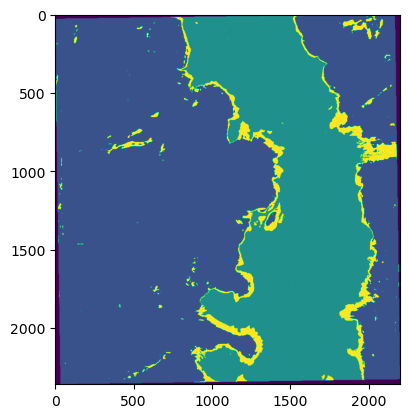

In [11]:
# Call the maximal map calculator and plot
raster, profile = calc_maximal_floodraster(geojsons_lst, True)
plt.imshow(raster)
plt.show()